In [1]:
# App imports
from flask import Flask, request, render_template_string, redirect, url_for
from flask_sqlalchemy import SQLAlchemy
from datetime import datetime
from threading import Thread

# Chart inputs
from collections import defaultdict
import matplotlib.pyplot as plt
from datetime import datetime

# JS imports
from io import BytesIO
import base64

In [2]:
# initializing flask app and sqlalchemy
app = Flask(__name__)
app.config['SQLALCHEMY_DATABASE_URI'] = 'sqlite:///names.db'
db = SQLAlchemy(app)

In [3]:
# creating model class
class Name(db.Model):
    id = db.Column(db.Integer, primary_key=True)
    name = db.Column(db.String(100), nullable=False)
    date_created = db.Column(db.DateTime, default=datetime.utcnow)
    rating = db.Column(db.Float, nullable=False)

In [4]:
# creating database
with app.app_context():
    db.create_all()

In [5]:
# defining Flask app routes
@app.route("/", methods=['GET', 'POST'])
def index():
    try:
        if request.method == 'POST':
            name = request.form['name']
            rating = float(request.form['rating'])
            new_name = Name(name=name, rating=rating)
            db.session.add(new_name)
            db.session.commit()
            return redirect("/")
    
        else:
            names = Name.query.order_by(Name.date_created).all()
            return render_template_string(index_html, names=names)
    except Exception as e:
        return f"An error occurred: {e}"

@app.route("/dashboard")
def dashboard():
    try:
        names = Name.query.order_by(Name.date_created).all()
        return render_template_string(dashboard_html, names=names)
    except Exception as e:
        return f"An error occured: {e}"

@app.route('/plot.png')
def plot_png():
    fig = plot_ratings()
    output = BytesIO()
    fig.savefig(output, format='png')
    output.seek(0)
    return send_file(output, mimetype='image/png')

def plot_ratings():
    with app.app_context():
        all_data = Name.query.all()
        # structure to hold the average rating for each name by day
        ratings_by_day = defaultdict(lambda: defaultdict(list))
        # Looping through data to populate ratings_by_day
        for data_point in all_data:
            day = data_point.date_created.date()
            name = data_point.name
            rating = data_point.rating
            
            # Appending ratings by day
            ratings_by_day[day][name].append(rating)
            
        # calculating daily average rating for each name
        avg_ratings_by_day = defaultdict(dict)
        for day, names in ratings_by_day.items():
            for name, ratings in names.items():
                avg_ratings_by_day[day][name] = sum(ratings) / len(ratings)
                
        # preparing data for plotting
        days = sorted(avg_ratings_by_day.keys())
        unique_names = set(name for names in avg_ratings_by_day.values() for name in names.keys())
        
        # creating plot object
        plt.figure(figsize=(12,8))
        
        for name in unique_names:
            avg_ratings = [avg_ratings_by_day[day].get(name, None) for day in days]
            plt.plot(days, avg_ratings, label=name)
            
        plt.xlabel('Day')
        plt.ylabel('Average Rating')
        plt.legend(title='Pledges')
        plt.title('Ranking of The Goats')
        plt.show()

    return plt.gcf()

In [6]:
# HTML code for index and dashboard
dashboard_html = '''
<!DOCTYPE html>
<html>
<head>
    <title>Dashboard</title>
</head>
<body style="font-family: Arial, sans-serif;">
    <h1 style="text-align:center;">Dashboard</h1>
    <hr>
    <h2>Previous Ratings</h2>
    <ul>
        {% for name in names %}
        <li>{{ name.name }} - {{ name.rating }}</li>
        {% endfor %}
    </ul>
</body>
</html>
<img id="plot" src="{{ url_for('plot_png') }}" alt="Ratings Plot">
<script type="text/javascript">
    function refreshImage(){
        var img = document.getElementById('plot');
        img.src = "{{ url_for('plot_png') }}" + "?" + new Date().getTime();
    }
    setInterval(refreshImage, 5000);  // Refresh every 5000 milliseconds (5 seconds)
</script>
'''

index_html = '''
<!DOCTYPE html>
<html>
<head>
    <title>Rate Names</title>
</head>
<body style="font-family: Arial, sans-serif;">
    <h1 style="text-align:center;">Rate Names</h1>
    <form method="post" action="/" style="text-align: center;">
        <label for="name">Name:</label>
        <input type="text" id="name" name="name" required><br><br>
        
        <label for="rating">Rating:</label>
        <input type="number" id="rating" name="rating" min="1" max="5" required><br><br>

        <input type="submit" value="Submit" style="padding: 5px 20px;">
    </form>
    <hr>
    <h2>Previous Ratings</h2>
    <ul>
        {% for name in names %}
        <li>{{ name.name }} - {{ name.rating }}</li>
        {% endfor %}
    </ul>
</body>
</html>
'''



In [7]:
# Running app in separate thread
def run_app():
    app.run(use_reloader=False, threaded=True)

app_thread = Thread(target=run_app)
app_thread.start()

In [ ]:
# http://127.0.0.1:5000

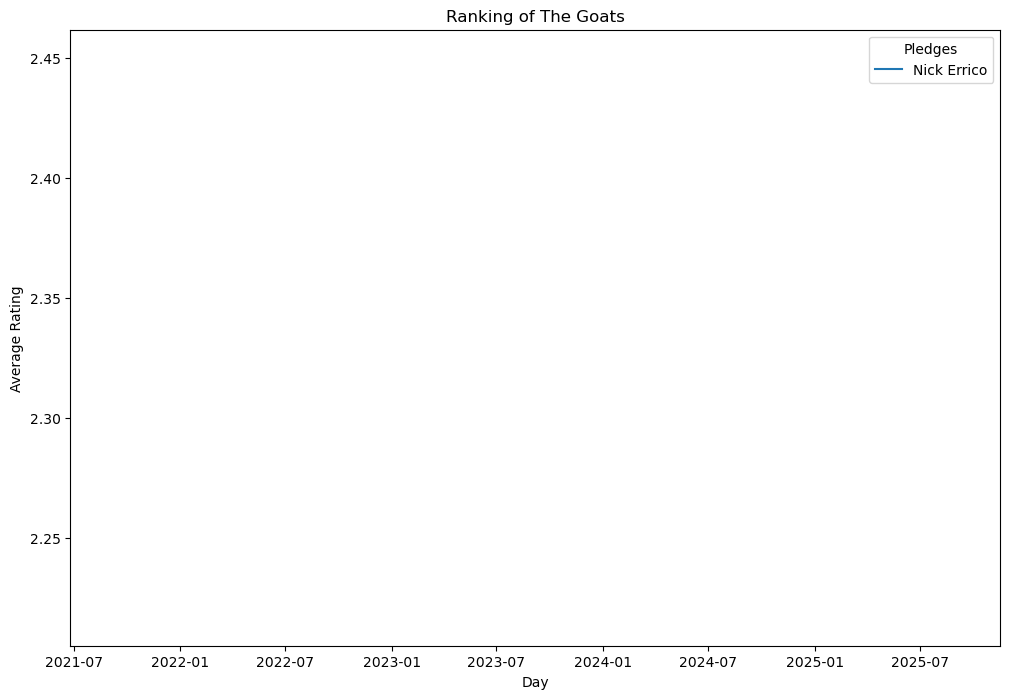

<Figure size 640x480 with 0 Axes>

In [8]:
plot_ratings()
plt.show()